In [ ]:
!pip install tensorflow-determinism

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9155 sha256=c67fb5fed687cb5c8def298a9175c279a52bc0b6dd1d971ce3a4ee4fd6d295bf
  Stored in directory: /root/.cache/pip/wheels/bf/5e/dd/9670c2d20867bcff6eb19199822f6b32f16bbe01bea1cd35a8
Successfully built tensorflow-determinism


# Setup

## Import

In [1]:
from shutil import copyfile
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os 
import random
from sklearn.metrics import mean_absolute_error as mae

In [2]:
keras.__version__

'2.10.0'

In [3]:
tf.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import data

In [4]:
df = pd.read_csv("./data/data2022_train.csv")
df = df.set_axis(["Date","y"], axis=1, inplace=False)

C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\2687461134.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(["Date","y"], axis=1, inplace=False)


In [9]:
df

,Date,y
0,2017-01-01 00:00:00,34055.69620
1,2017-01-01 00:10:00,29814.68354
2,2017-01-01 00:20:00,29128.10127
3,2017-01-01 00:30:00,28228.86076
4,2017-01-01 00:40:00,27335.69620
...,...,...
48091,2017-11-30 23:10:00,31347.69231
48092,2017-11-30 23:20:00,30603.07692
48093,2017-11-30 23:30:00,29889.23077
48094,2017-11-30 23:40:00,29249.23077


In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]
df = df.drop("Date",axis=1)

In [8]:
df["sample"] = "train"
df["sample"].loc[df.index>="2017-11-01"] = "test"

C:\Users\giorg\AppData\Local\Temp\ipykernel_15876\185039692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sample"].loc[df.index>="2017-11-01"] = "test"


In [6]:
df.head()

,y
Date,
2017-01-01 00:00:00,34055.69620
2017-01-01 00:10:00,29814.68354
2017-01-01 00:20:00,29128.10127
2017-01-01 00:30:00,28228.86076
2017-01-01 00:40:00,27335.69620


Normalizzare rispetto alla media

In [13]:
y_mean = np.mean(df.loc[df["sample"]=="train","y"])
y_std = np.std(df.loc[df["sample"]=="train","y"])

df["y"] = (df["y"] - y_mean)/y_std

In [14]:
# print df["y"] min and max
print(df["y"].min())
print(df["y"].max())

-2.674076076416834
2.6873650903202497


## Funzioni

In [15]:
def inv_diff(s,h0,p = 144):
  s0 = h0.append(s)
  n = len(s0)//p
  for i in range(n-1):
    s0[((i+1)*p):((i+2)*p)] = s0[((i)*p):((i+1)*p)].values + s0[((i+1)*p):((i+2)*p)].values
  return s0

In [16]:
def transform_ts(df,r=30,shift=144,colname="y"):
  df_array = np.array([[np.nan]*(r)]*df.shape[0])
  df_array[:,0] = df[colname]
  for l in range(1,r):
    df_array[:,l] = df[colname].shift(l*shift)
  
  leadnames = ["y_{t+"+str(i*shift)+"}" for i in range(r-1,0,-1)]
  colnames = leadnames+["y_t"]
  final_df = pd.DataFrame(df_array,columns=colnames)
  # rimosse righe con almeno un NA (questo è ciò che fa ridurre il numero di righe della matrice)
  final_df = final_df.dropna()
  final_df = final_df.loc[:,final_df.columns[::-1]]
  return np.reshape(final_df.values,(final_df.shape[0],final_df.shape[1],1))

## Primo Modello (intera serie storica)

### Regressori

Preparazione dei regressori e della variabile target, che saranno laggati di 4320 osservazioni (x rispetto a y è 4230 osservazioni indietro, ovviamente non si possono usare le prime 4320 come target):
- x e y (per i vari split) avranno lo stesso numero di righe
- ma y sarà shiftata 4320 osservazioni in avanti
- alla prima osservazione di y corrisponderà l'osservazione 4320 osservazioni prima (lag = 4320)
- y_train partirà dalla 4320esima osservazione (così da non avere NAN nei ritardi) -> quindi dal 31-01

In [70]:
x_train = df[:(4320*5)][["y"]]
y_train = df[4320:4320*6][["y"]]

In [71]:
# find min index and max index in x_train
print(x_train.index.min(), x_train.index.max())
print(y_train.index.min(), y_train.index.max())
print(len(x_train), len(y_train))
print(x_train.shape, y_train.shape)

2017-01-01 00:00:00 2017-05-30 23:50:00
2017-01-31 00:00:00 2017-06-29 23:50:00
21600 21600
(21600, 1) (21600, 1)


In [276]:
x_val = df[4320*5:4320*9][["y"]]
y_val = df[4320*6:4320*10][["y"]]

In [284]:
print(y_val.index.min(), y_val.index.max())
print(len(x_val), len(y_val))

2017-06-30 00:00:00 2017-10-27 23:50:00
17280 17280


In [278]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y"]]
y_test = df[(4320*10+144*4):][["y"]]

In [285]:
print(y_test.index.min(), y_test.index.max())
print(len(x_test), len(y_test))

2017-11-01 00:00:00 2017-11-30 23:50:00
4320 4320


In [280]:
x_train.head()

,y
Date,
2017-01-01 00:00:00,0.147389
2017-01-01 00:10:00,-0.446156
2017-01-01 00:20:00,-0.542246
2017-01-01 00:30:00,-0.668098
2017-01-01 00:40:00,-0.793099


In [281]:
y_train.head()

,y
Date,
2017-01-31 00:00:00,-0.382380
2017-01-31 00:10:00,-0.470816
2017-01-31 00:20:00,-0.544797
2017-01-31 00:30:00,-0.648540
2017-01-31 00:40:00,-0.789698


Generazione x e y da passare alla rete.

transform_ts prende le serie storiche e le trasforma in matrici dove:
- per train e validation
  - il numero di righe è il la lunghezza della serie storica -4320 (paramertro r, ritardo)
  - la prima colonna è la serie storicha di partenza dove mancano in fondo le ultime 4230 osservazioni (paramertro r, ritardo)
  - In tutte le altre colonne, per ogni riga, saranno presenti le 4320 osservazioni successive a quella nella prima colonna (per questo non ho le ultime r righe, perchè avrei NA altrimenti)
  - Per le y varrà la stessa cosa solo che i valori da cui parte saranno shiftati in avanti di 4230 
    - Ha senso perchè
      - Ogni riga delle x saranno 4230 osservazioni successive che vanno da i a j
      - Ogni riga delle y saranno 4230 osservazioni successive che vanno da i+4230 a j+4230
      - Quindi io uso 4230 osservazioni nel passato (lag) per prevedere 4230 osservazioni nel futuro (lead)
- Pe ril test invece ho solo 4230 righe ripetute dei 4230 valori di novemembre


In [317]:
x_train_df = transform_ts(x_train,r=4320,shift=1)[:-1,:,:]
y_train_df = transform_ts(y_train,r=4320,shift=1)[:-1,:,:]
x_val_df = transform_ts(x_val,r=4320,shift=1)[:-1,:,:]
y_val_df = transform_ts(y_val,r=4320,shift=1)[:-1,:,:]
x_test_df = transform_ts(x_test,r=4320,shift=1).repeat(144,axis=0)
y_test_df = transform_ts(y_test,r=4320,shift=1).repeat(144,axis=0)

In [288]:
21600 - 4320

17280

In [322]:
print(x_train_df.shape)
print(pd.DataFrame(x_train_df[0:5, 0:5, 0]))
print(y_train_df.shape)
print(pd.DataFrame(y_train_df[0:5, 0:5, 0]))

(17280, 4320, 1)
          0         1         2         3         4
0  0.147389 -0.446156 -0.542246 -0.668098 -0.793099
1 -0.446156 -0.542246 -0.668098 -0.793099 -0.892590
2 -0.542246 -0.668098 -0.793099 -0.892590 -0.980177
3 -0.668098 -0.793099 -0.892590 -0.980177 -1.057559
4 -0.793099 -0.892590 -0.980177 -1.057559 -1.151097
(17280, 4320, 1)
          0         1         2         3         4
0 -0.382380 -0.470816 -0.544797 -0.648540 -0.789698
1 -0.470816 -0.544797 -0.648540 -0.789698 -0.944462
2 -0.544797 -0.648540 -0.789698 -0.944462 -0.976775
3 -0.648540 -0.789698 -0.944462 -0.976775 -0.999735
4 -0.789698 -0.944462 -0.976775 -0.999735 -1.066062


In [323]:
print(x_test_df.shape)
print(pd.DataFrame(x_test_df[0:5, 0:5, 0]))
print(y_test_df.shape)
print(pd.DataFrame(y_test_df[0:5, 0:5, 0]))

(144, 4320, 1)
          0         1         2         3         4
0 -0.338563 -0.444401 -0.524662 -0.581109 -0.619916
1 -0.338563 -0.444401 -0.524662 -0.581109 -0.619916
2 -0.338563 -0.444401 -0.524662 -0.581109 -0.619916
3 -0.338563 -0.444401 -0.524662 -0.581109 -0.619916
4 -0.338563 -0.444401 -0.524662 -0.581109 -0.619916
(144, 4320, 1)
          0         1         2         3         4
0 -0.827593 -0.881852 -0.927498 -0.985202 -1.036878
1 -0.827593 -0.881852 -0.927498 -0.985202 -1.036878
2 -0.827593 -0.881852 -0.927498 -0.985202 -1.036878
3 -0.827593 -0.881852 -0.927498 -0.985202 -1.036878
4 -0.827593 -0.881852 -0.927498 -0.985202 -1.036878


In [103]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [104]:
train_dataset = train_dataset.batch(144)
val_dataset = val_dataset.batch(144)
test_dataset = test_dataset.batch(144)

In [105]:
for batch in train_dataset.take(1):
    inputs, targets = batch

In [106]:
learning_rate = 0.001
epochs = 5

In [107]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=144)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(4320)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [108]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(144, 4320, 1)]          0         
                                                                 
 gru (GRU)                   (144, 4320, 16)           912       
                                                                 
 gru_1 (GRU)                 (144, 16)                 1632      
                                                                 
 dense (Dense)               (144, 4320)               73440     
                                                                 
Total params: 75,984
Trainable params: 75,984
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/5
120/120 [==============================] - 69s 532ms/step - loss: 0.7309 - val_loss: 0.7617
Epoch 2/5
120/120 [==============================] - 65s 544ms/step - loss: 0.6674 - val_loss: 0.7799
Epoch 3/5
120/120 [==============================] - 65s 542ms/step - loss: 0.5842 - val_loss: 0.7751
Epoch 4/5
120/120 [==============================] - 65s 546ms/step - loss: 0.4968 - val_loss: 0.8205
Epoch 5/5
120/120 [==============================] - 65s 545ms/step - loss: 0.4443 - val_loss: 0.8430


In [113]:
y_pred = net.predict(test_dataset)
y_test["pred"] = y_pred[0,:]
y_test_adj = y_test*y_std+y_mean

1/1 [==============================] - 0s 359ms/step


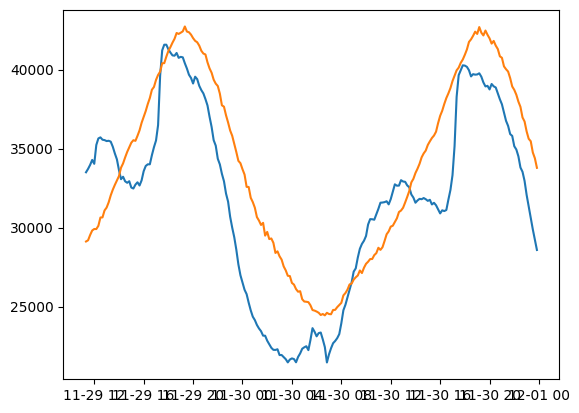

In [114]:
plt.plot(y_test_adj["y"][4100:])
plt.plot(y_test_adj["pred"][4100:])

In [115]:
mae(y_test_adj["y"],y_test_adj["pred"])

3291.049259136719

In [116]:
pred_month = y_test_adj["pred"]

## Secondo modello

Vettore con tutte le (30) 00:00:10 di gennaio per prevedere tutte quelle di febbraio (30)


In [336]:
# Vettore con tutte le (30) 00:00:10 di gennaio per prevedere tutte quelle di febbraio (30)

# gennaio
x_train_1 = df[:(4320)][["y"]]
#febbraio
y_train_1 = df[(4320):(4320*2)][["y"]]

#febbraio
x_train_2 = df[(4320):(4320*2)][["y"]]
# marzo
y_train_2 = df[(4320*2):(4320*3)][["y"]]

x_train_3 = df[(4320*2):(4320*3)][["y"]]
y_train_3 = df[(4320*3):(4320*4)][["y"]]

x_train_4 = df[(4320*3):(4320*4)][["y"]]
y_train_4 = df[(4320*4):(4320*5)][["y"]]

x_train_5 = df[4320*4:4320*5][["y"]]
y_train_5 = df[4320*5:4320*6][["y"]]

In [337]:
x_val_1 = df[4320*5:4320*6][["y"]]
y_val_1 = df[4320*6:4320*7][["y"]]

x_val_2 = df[4320*6:4320*7][["y"]]
y_val_2 = df[4320*7:4320*8][["y"]]

x_val_3 = df[4320*7:4320*8][["y"]]
y_val_3 = df[4320*8:4320*9][["y"]]

x_val_4 = df[4320*8:4320*9][["y"]]
y_val_4 = df[4320*9:4320*10][["y"]]

In [338]:
# ottobre
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y"]]
# novembre
y_test = df[(4320*10+144*4):][["y"]]

In [339]:
print(x_train_1.index.min(), x_train_1.index.max())
print(y_train_1.index.min(), y_train_1.index.max())
print(len(x_train_1), len(y_train_1))
print(x_train_1.shape, y_train_1.shape)

2017-01-01 00:00:00 2017-01-30 23:50:00
2017-01-31 00:00:00 2017-03-01 23:50:00
4320 4320
(4320, 1) (4320, 1)


In [340]:
print(x_train_2.index.min(), x_train_2.index.max())
print(y_train_2.index.min(), y_train_2.index.max())
print(len(x_train_2), len(y_train_2))
print(x_train_2.shape, y_train_2.shape)

2017-01-31 00:00:00 2017-03-01 23:50:00
2017-03-02 00:00:00 2017-03-31 23:50:00
4320 4320
(4320, 1) (4320, 1)


In [341]:
print(x_test.index.min(), x_test.index.max())
print(y_test.index.min(), y_test.index.max())
print(len(x_test), len(y_test))
print(x_test.shape, y_test.shape)

2017-10-02 00:00:00 2017-10-31 23:50:00
2017-11-01 00:00:00 2017-11-30 23:50:00
4320 4320
(4320, 1) (4320, 1)


In [342]:
x_train_df = np.concatenate((transform_ts(x_train_1),
                            transform_ts(x_train_2),
                            transform_ts(x_train_3),
                            transform_ts(x_train_4),
                            transform_ts(x_train_5)),axis=0)

y_train_df = np.concatenate((transform_ts(y_train_1),
                            transform_ts(y_train_2),
                            transform_ts(y_train_3),
                            transform_ts(y_train_4),
                            transform_ts(y_train_5)),axis=0)



In [343]:
x_train_df.shape

(720, 30, 1)

In [344]:
print(x_train_df.shape)
print(pd.DataFrame(x_train_df[0:5, 0:5, 0]))
print(y_train_df.shape)
print(pd.DataFrame(y_train_df[0:5, 0:5, 0]))

(720, 30, 1)
          0         1         2         3         4
0  0.147389 -0.881536 -0.887488 -0.748031 -0.747180
1 -0.446156 -0.956367 -0.958918 -0.818610 -0.879835
2 -0.542246 -1.032898 -1.059259 -0.918101 -0.951265
3 -0.668098 -1.123886 -1.127287 -0.972523 -1.032898
4 -0.793099 -1.198717 -1.184261 -1.046504 -1.101777
(720, 30, 1)
          0         1         2         3         4
0 -0.382380 -0.435307 -0.298674 -0.394317 -0.373822
1 -0.470816 -0.548029 -0.448116 -0.476297 -0.457510
2 -0.544797 -0.665875 -0.553153 -0.577063 -0.534366
3 -0.648540 -0.729067 -0.647942 -0.664167 -0.624031
4 -0.789698 -0.799945 -0.738461 -0.749562 -0.704303


In [122]:
x_val_df = np.concatenate((transform_ts(x_val_1),
                          transform_ts(x_val_2),
                          transform_ts(x_val_3),
                          transform_ts(x_val_4)),axis=0)

y_val_df = np.concatenate((transform_ts(y_val_1),
                          transform_ts(y_val_2),
                          transform_ts(y_val_3),
                          transform_ts(y_val_4)),axis=0)



In [123]:
x_val_df.shape

(576, 30, 1)

In [124]:
x_test_df = transform_ts(x_test)
y_test_df = transform_ts(y_test)

In [125]:
x_test_df.shape

(144, 30, 1)

In [126]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [127]:
train_dataset = train_dataset.batch(24)
val_dataset = val_dataset.batch(24)
test_dataset = test_dataset.batch(24)

In [128]:
learning_rate = 0.001
epochs =30

In [129]:
for batch in train_dataset.take(1):
    inputs, targets = batch

In [130]:
# Architecture definition v2


inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=24)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(30)(x)
x = keras.layers.Reshape([30, 1])(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [131]:

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(24, 30, 1)]             0         
                                                                 
 gru_2 (GRU)                 (24, 30, 16)              912       
                                                                 
 gru_3 (GRU)                 (24, 16)                  1632      
                                                                 
 dense_1 (Dense)             (24, 30)                  510       
                                                                 
 reshape (Reshape)           (24, 30, 1)               0         
                                                                 
Total params: 3,054
Trainable params: 3,054
Non-trainable params: 0
_________________________________________________________________


In [132]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/30


30/30 [==============================] - 2s 30ms/step - loss: 0.7644 - val_loss: 0.7104
Epoch 2/30
30/30 [==============================] - 0s 9ms/step - loss: 0.6021 - val_loss: 0.5320
Epoch 3/30
30/30 [==============================] - 0s 9ms/step - loss: 0.4249 - val_loss: 0.4493
Epoch 4/30
30/30 [==============================] - 0s 9ms/step - loss: 0.3286 - val_loss: 0.4017
Epoch 5/30
30/30 [==============================] - 0s 9ms/step - loss: 0.2774 - val_loss: 0.3864
Epoch 6/30
30/30 [==============================] - 0s 9ms/step - loss: 0.2541 - val_loss: 0.3817
Epoch 7/30
30/30 [==============================] - 0s 10ms/step - loss: 0.2437 - val_loss: 0.3806
Epoch 8/30
30/30 [==============================] - 0s 9ms/step - loss: 0.2382 - val_loss: 0.3796
Epoch 9/30
30/30 [==============================] - 0s 10ms/step - loss: 0.2342 - val_loss: 0.3789
Epoch 10/30
30/30 [==============================] - 0s 10ms/step - loss: 0.2310 - val_loss: 0.3788
Epoch 11/30
30/30 [=======

In [133]:
y_pred = net.predict(test_dataset)

6/6 [==============================] - 0s 4ms/step


In [134]:
pred_arr = np.array([])
for i in range(0,y_pred.shape[1]):
  pred_arr =np.concatenate((pred_arr,np.reshape(y_pred[:,i],(144))))

y_test["pred"] = pred_arr
y_test_adj = y_test*y_std+y_mean

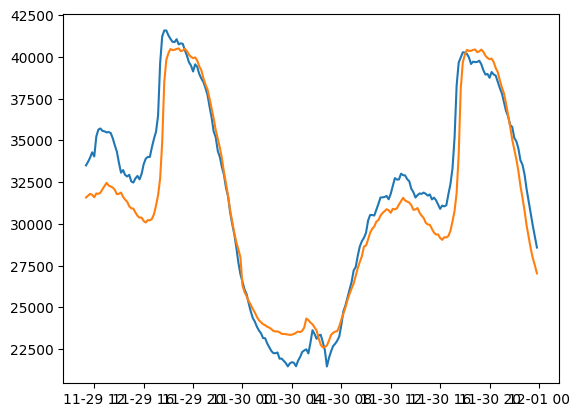

In [135]:
plt.plot(y_test_adj["y"][4100:])
plt.plot(y_test_adj["pred"][4100:])

In [137]:
mae(y_test_adj["y"],y_test_adj["pred"])

1708.505633278365

In [138]:
pred_day = y_test_adj["pred"]

## Terzo

Previsioni su Diff Y

In [347]:
df.head()

,y,sample,y_d
Date,,,
2017-01-01 00:00:00,0.147389,train,NaN
2017-01-01 00:10:00,-0.446156,train,NaN
2017-01-01 00:20:00,-0.542246,train,NaN
2017-01-01 00:30:00,-0.668098,train,NaN
2017-01-01 00:40:00,-0.793099,train,NaN


In [346]:
h0 = df["y"][0:144]
df["y_d"] = df["y"].diff(144)

In [348]:
x_train = df[144:(4320*5)][["y_d"]]
y_train = df[(4320+144):4320*6][["y_d"]]

In [141]:
x_val = df[4320*5:4320*9][["y_d"]]
y_val = df[4320*6:4320*10][["y_d"]]

In [142]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y_d"]]
y_test = df[(4320*10+144*4):][["y_d"]]

In [143]:
x_train_df = transform_ts(x_train,r=4320,shift=1,colname="y_d")[:-1,:,:]
y_train_df = transform_ts(y_train,r=4320,shift=1,colname="y_d")[:-1,:,:]
x_val_df = transform_ts(x_val,r=4320,shift=1,colname="y_d")[:-1,:,:]
y_val_df = transform_ts(y_val,r=4320,shift=1,colname="y_d")[:-1,:,:]
x_test_df = transform_ts(x_test,r=4320,shift=1,colname="y_d").repeat(144,axis=0)
y_test_df = transform_ts(y_test,r=4320,shift=1,colname="y_d").repeat(144,axis=0)

In [144]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [145]:
train_dataset = train_dataset.batch(144)
val_dataset = val_dataset.batch(144)
test_dataset = test_dataset.batch(144)

In [146]:
for batch in train_dataset.take(1):
    inputs, targets = batch

In [147]:
learning_rate = 0.001
epochs = 5

In [148]:
# Architecture definition v2

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=144)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(4320)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [149]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(144, 4320, 1)]          0         
                                                                 
 gru_4 (GRU)                 (144, 4320, 16)           912       
                                                                 
 gru_5 (GRU)                 (144, 16)                 1632      
                                                                 
 dense_2 (Dense)             (144, 4320)               73440     
                                                                 
Total params: 75,984
Trainable params: 75,984
Non-trainable params: 0
_________________________________________________________________


In [150]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/5
119/119 [==============================] - 65s 535ms/step - loss: 0.1865 - val_loss: 0.1917
Epoch 2/5
119/119 [==============================] - 60s 509ms/step - loss: 0.1859 - val_loss: 0.1915
Epoch 3/5
119/119 [==============================] - 60s 505ms/step - loss: 0.1858 - val_loss: 0.1914
Epoch 4/5
119/119 [==============================] - 61s 516ms/step - loss: 0.1858 - val_loss: 0.1914
Epoch 5/5
119/119 [==============================] - 61s 511ms/step - loss: 0.1858 - val_loss: 0.1914


In [151]:
y_pred = net.predict(test_dataset)

1/1 [==============================] - 1s 543ms/step


In [152]:
y_d = df["y_d"]


In [153]:
y_d[-4320:]=y_pred[0,:]
inv_pred = inv_diff(y_d.dropna(),h0)

y_test["pred"] = inv_pred[-4320:]
y_test["y"] = df["y"][-4320:]
y_test_adj = y_test*y_std+y_mean

C:\Users\giorg\AppData\Local\Temp\ipykernel_12016\3953423557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_d[-4320:]=y_pred[0,:]
C:\Users\giorg\AppData\Local\Temp\ipykernel_12016\70647333.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s0 = h0.append(s)


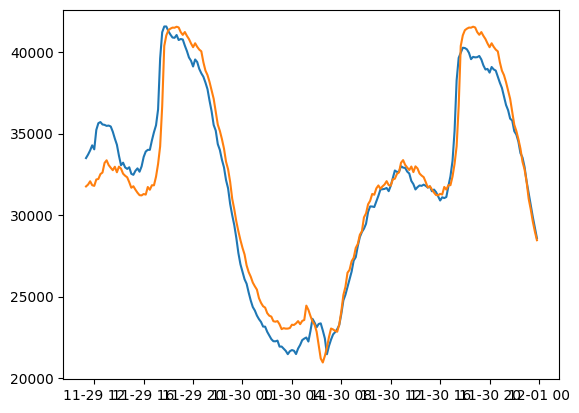

In [154]:
plt.plot(y_test_adj["y"][4100:])
plt.plot(y_test_adj["pred"][4100:])

In [155]:
mae(y_test_adj["y"],y_test_adj["pred"])

1532.991481416425

In [156]:
pred_diffmonth = y_test_adj["pred"]

## Miglior tentativo

In [17]:
import random
import os

Differenziamo per poi applicare inv diff sulle predizioni

In [18]:
h0 = df["y"][0:144]
# ogni elemento viene sottratto a 144-esimo precedente (stesso minuto del giorno prima)
df["y_d"] = df["y"].diff(144)

In [19]:
df[144:170]

,y,sample,y_d
Date,,,
2017-01-02 00:00:00,-0.881536,train,-1.028925
2017-01-02 00:10:00,-0.956367,train,-0.510211
2017-01-02 00:20:00,-1.032898,train,-0.490653
2017-01-02 00:30:00,-1.123886,train,-0.455788
2017-01-02 00:40:00,-1.198717,train,-0.405617
2017-01-02 00:50:00,-1.271847,train,-0.379257
2017-01-02 01:00:00,-1.311814,train,-0.331637
2017-01-02 01:10:00,-1.383243,train,-0.325684
2017-01-02 01:20:00,-1.436815,train,-0.285718


Creo dei training set:
- Ogni x sono le osservazioni di un mese
- ogni y sono le osservazioni del mese successivo
- es. train1 ha le osservazioni di gennaio, y_train1 di febbraio
  - train 5 (l'ultima y usata nel training sono le osservazioni di giugno, mentre nel training finale usiamo fino a quelle di luglio)

In [20]:
x_train_1 = df[144:(4320)][["y_d"]]
y_train_1 = df[(4320+144):(4320*2)][["y_d"]]

x_train_2 = df[(4320):(4320*2)][["y_d"]]
y_train_2 = df[(4320*2):(4320*3)][["y_d"]]

x_train_3 = df[(4320*2):(4320*3)][["y_d"]]
y_train_3 = df[(4320*3):(4320*4)][["y_d"]]

x_train_4 = df[(4320*3):(4320*4)][["y_d"]]
y_train_4 = df[(4320*4):(4320*5)][["y_d"]]

x_train_5 = df[4320*4:4320*5][["y_d"]]
y_train_5 = df[4320*5:4320*6][["y_d"]]

x_val_1 = df[4320*5:4320*6][["y_d"]]
y_val_1 = df[4320*6:4320*7][["y_d"]]


In [21]:

x_val_2 = df[4320*6:4320*7][["y_d"]]
y_val_2 = df[4320*7:4320*8][["y_d"]]

x_val_3 = df[4320*7:4320*8][["y_d"]]
y_val_3 = df[4320*8:4320*9][["y_d"]]

x_val_4 = df[4320*8:4320*9][["y_d"]]
y_val_4 = df[4320*9:4320*10][["y_d"]]

In [22]:
x_test = df[(4320*9+144*4):(4320*10+144*4)][["y_d"]]
y_test = df[(4320*10+144*4):][["y_d"]]

In [23]:
print(type(x_train_1))
print(x_train_1.index.min(), x_train_1.index.max())
print(y_train_1.index.min(), y_train_1.index.max())
print(len(x_train_1), len(y_train_1))
print(x_train_1.shape, y_train_1.shape)

<class 'pandas.core.frame.DataFrame'>
2017-01-02 00:00:00 2017-01-30 23:50:00
2017-02-01 00:00:00 2017-03-01 23:50:00
4176 4176
(4176, 1) (4176, 1)


transform_ts -> Ottengo le matrici di training e validation
- uso 30 ritardi con uno shift di 144
- Questo significa che dalla serie storica ottengo una matrice con 30 colonne
  - La prima colonna sono le prime 144 osservazioni della serie storica passata
  - Le altre colonne sono le trenta osservazioni successive prese ogni 144
    - Quindi di fatto avremo in queste colonne le osservazioni dei 30 giorni successivi per lo stesso minuto
- Il numero di righe generato (es. su x_train_1) è sempre 144, questo perchè così avremo una osservazione per ogni 10 minuti
- Quindi transform in questo caso genera una matrice dove ogni riga è associata alle 30 osservazioni, nei 30 giorni del mese, per un certo minuto della giornata
  - Quindi la prima colonna saranno le prime 144 osservazioni della prima giornata
  - La seconda della seconda giornata
- Concatenando ottengo una matrice con questi dati per tutti i mesi inclusi (train 1-5 hanno fino a giugno)

In [24]:
x_train_df = np.concatenate((transform_ts(x_train_1,colname="y_d"),
                            transform_ts(x_train_2,colname="y_d"),
                            transform_ts(x_train_3,colname="y_d"),
                            transform_ts(x_train_4,colname="y_d"),
                            transform_ts(x_train_5,colname="y_d")),axis=0)

y_train_df = np.concatenate((transform_ts(y_train_1,colname="y_d"),
                            transform_ts(y_train_2,colname="y_d"),
                            transform_ts(y_train_3,colname="y_d"),
                            transform_ts(y_train_4,colname="y_d"),
                            transform_ts(y_train_5,colname="y_d")),axis=0)



In [25]:
x_val_df = np.concatenate((transform_ts(x_val_1,colname="y_d"),
                          transform_ts(x_val_2,colname="y_d"),
                          transform_ts(x_val_3,colname="y_d"),
                          transform_ts(x_val_4,colname="y_d")),axis=0)

y_val_df = np.concatenate((transform_ts(y_val_1,colname="y_d"),
                          transform_ts(y_val_2,colname="y_d"),
                          transform_ts(y_val_3,colname="y_d"),
                          transform_ts(y_val_4,colname="y_d")),axis=0)



In [26]:
x_test_df = transform_ts(x_test,colname="y_d")
y_test_df = transform_ts(y_test,colname="y_d")

In [27]:
print(x_train_df.shape)
print(pd.DataFrame(x_train_df[0:5, 0:5, 0]))
print(y_train_df.shape)
print(pd.DataFrame(y_train_df[0:5, 0:5, 0]))

(576, 30, 1)
          0         1         2         3         4
0 -0.031463 -0.052927  0.136633 -0.095643  0.020495
1 -0.017007 -0.077213  0.099913 -0.028180  0.018787
2  0.015306 -0.121078  0.112722 -0.023911  0.042698
3  0.006803 -0.080528  0.081126 -0.016225  0.040136
4 -0.043368 -0.010247  0.061485 -0.011101  0.045260
(576, 30, 1)
          0         1         2         3         4
0  0.019725  0.089189 -0.038591  0.193815 -0.134641
1 -0.012864  0.091762 -0.024012  0.163799 -0.137214
2  0.005146  0.088332 -0.018009  0.120920 -0.086616
3 -0.000858  0.061746 -0.003430  0.116632 -0.064319
4 -0.040307  0.042022 -0.002573  0.148363 -0.092620


In [703]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df, y_test_df))

In [704]:
train_dataset = train_dataset.batch(72)
val_dataset = val_dataset.batch(72)
test_dataset = test_dataset.batch(72)

In [705]:
learning_rate = 0.001
epochs = 40

In [706]:
for batch in train_dataset.take(1):
    inputs, targets = batch


In [707]:
glo_init = tf.keras.initializers.GlorotUniform(seed=1)
ort_init= tf.keras.initializers.Orthogonal(seed=1)

La rete quindi imparerà a prevedere, dati le osservazioni dell'x-esimo minuto di un mese, a prevedere quelle dell'x-esimo minuto del mese dopo (ecco perchè layer denso da 30 neuroni)

In [708]:

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=72)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(30)(x)
x = keras.layers.Reshape([30, 1])(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [709]:

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(72, 30, 1)]             0         
                                                                 
 gru_40 (GRU)                (72, 30, 16)              912       
                                                                 
 gru_41 (GRU)                (72, 16)                  1632      
                                                                 
 dense_20 (Dense)            (72, 30)                  510       
                                                                 
 reshape_18 (Reshape)        (72, 30, 1)               0         
                                                                 
Total params: 3,054
Trainable params: 3,054
Non-trainable params: 0
_________________________________________________________________


In [710]:
history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/40


8/8 [==============================] - 3s 111ms/step - loss: 0.1961 - val_loss: 0.1925
Epoch 2/40
8/8 [==============================] - 0s 22ms/step - loss: 0.1941 - val_loss: 0.1934
Epoch 3/40
8/8 [==============================] - 0s 18ms/step - loss: 0.1932 - val_loss: 0.1943
Epoch 4/40
8/8 [==============================] - 0s 17ms/step - loss: 0.1927 - val_loss: 0.1949
Epoch 5/40
8/8 [==============================] - 0s 17ms/step - loss: 0.1923 - val_loss: 0.1953
Epoch 6/40
8/8 [==============================] - 0s 19ms/step - loss: 0.1919 - val_loss: 0.1956
Epoch 7/40
8/8 [==============================] - 0s 16ms/step - loss: 0.1916 - val_loss: 0.1959
Epoch 8/40
8/8 [==============================] - 0s 17ms/step - loss: 0.1913 - val_loss: 0.1961
Epoch 9/40
8/8 [==============================] - 0s 15ms/step - loss: 0.1910 - val_loss: 0.1963
Epoch 10/40
8/8 [==============================] - 0s 16ms/step - loss: 0.1908 - val_loss: 0.1966
Epoch 11/40
8/8 [======================

In [711]:
y_pred = net.predict(test_dataset)

2/2 [==============================] - 1s 6ms/step


Predizioni:
- ottengo una matrice simile a quella generata da transform_ts
- Ogni riga è associata a un minutaggio della giornata (infatti sono in tutto 144)
- Ogni colonna è un giorno del mese (30)
- Ogni cella è l'osservazione prevista per quel minuto/giorno

In [712]:
y_pred.shape

(144, 30, 1)

Per ricostruire la serie storica dovrò quindi srotolare la matrice, concatenando le colonne una dopo l'altra

In [713]:
pred_arr = np.array([])
for i in range(0,y_pred.shape[1]):
  pred_arr =np.concatenate((pred_arr,np.reshape(y_pred[:,i],(144))))

y_d = df["y_d"]
y_d[-4320:]=pred_arr

inv_pred = inv_diff(y_d.dropna(),h0)

y_test["pred"] = inv_pred[-4320:]
y_test["y"] = df["y"][-4320:]

y_test_adj = y_test*y_std+y_mean


C:\Users\giorg\AppData\Local\Temp\ipykernel_12016\4183447401.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_d[-4320:]=pred_arr
C:\Users\giorg\AppData\Local\Temp\ipykernel_12016\70647333.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s0 = h0.append(s)


In [717]:
y_test_adj["pred"].to_csv("./data/previsioni/LSTM_validation.csv")

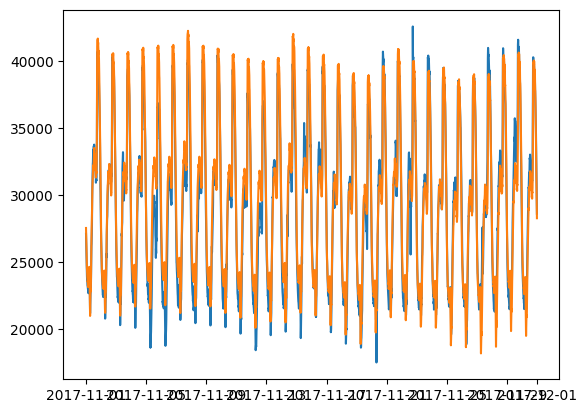

In [714]:
plt.plot(y_test_adj["y"])
plt.plot(y_test_adj["pred"])

In [715]:
mae(y_test_adj["y"],y_test_adj["pred"])

1184.0733103131238

In [176]:
pred_diffday = y_test_adj["pred"]

In [363]:
pred_df = pd.DataFrame({"month":pred_month,"day":pred_day,"diffmonth":pred_diffmonth,"diffday":pred_diffday})

In [364]:
pred_df.to_csv("pred_lstm.csv")

PREVISIONI (train su intero)

In [718]:
h0 = df["y"][0:144]
df["y_d"] = df["y"].diff(144)

In [719]:
x_train_1 = df[144:(4608)][["y_d"]]
y_train_1 = df[(4608):(9072)][["y_d"]]

x_train_2 = df[(4608):(9072)][["y_d"]]
y_train_2 = df[(9072):(13536)][["y_d"]]

x_train_3 = df[(9072):(13536)][["y_d"]]
y_train_3 = df[(13536):(18000)][["y_d"]]

x_train_4 = df[(13536):(18000)][["y_d"]]
y_train_4 = df[(18000):(22464)][["y_d"]]

x_train_5 = df[(18000):(22464)][["y_d"]]
y_train_5 = df[(22464):(26928)][["y_d"]]

x_train_6 = df[(22464):(26928)][["y_d"]]
y_train_6 = df[(26928):(31392)][["y_d"]]


In [720]:
x_val_1 = df[(26928):(31392)][["y_d"]]
y_val_1 = df[(31392):(35856)][["y_d"]]

x_val_2 = df[(31392):(35856)][["y_d"]]
y_val_2 = df[(35856):(40320)][["y_d"]]

x_val_3 = df[(35856):(40320)][["y_d"]]
y_val_3 = df[(40320):(44784)][["y_d"]]


In [721]:
print(type(y_train_6))
print(y_train_6.index.min(), y_train_6.index.max())
print(len(y_train_6))
print(y_train_6.shape)

<class 'pandas.core.frame.DataFrame'>
2017-07-07 00:00:00 2017-08-06 23:50:00
4464
(4464, 1)


In [722]:
x_test = df[-4464:][["y_d"]]
#x_test = df[-4320:][["y_d"]]

In [723]:
print(type(x_test))
print(x_test.index.min(), x_test.index.max())
print(len(x_test))
print(x_test.shape)

<class 'pandas.core.frame.DataFrame'>
2017-10-31 00:00:00 2017-11-30 23:50:00
4464
(4464, 1)


In [724]:
x_train_df = np.concatenate((transform_ts(x_train_1,r=31,colname="y_d"),
                            transform_ts(x_train_2,r=31,colname="y_d"),
                            transform_ts(x_train_3,r=31,colname="y_d"),
                            transform_ts(x_train_4,r=31,colname="y_d"),
                            transform_ts(x_train_5,r=31,colname="y_d"),
                            transform_ts(x_train_6,r=31,colname="y_d")),axis=0)

y_train_df = np.concatenate((transform_ts(y_train_1,r=31,colname="y_d"),
                            transform_ts(y_train_2,r=31,colname="y_d"),
                            transform_ts(y_train_3,r=31,colname="y_d"),
                            transform_ts(y_train_4,r=31,colname="y_d"),
                            transform_ts(y_train_5,r=31,colname="y_d"),
                            transform_ts(y_train_6,r=31,colname="y_d")),axis=0)



In [725]:
x_val_df = np.concatenate((transform_ts(x_val_1,r=31,colname="y_d"),
                          transform_ts(x_val_2,r=31,colname="y_d"),
                          transform_ts(x_val_3,r=31,colname="y_d")),axis=0)

y_val_df = np.concatenate((transform_ts(y_val_1,r=31,colname="y_d"),
                          transform_ts(y_val_2,r=31,colname="y_d"),
                          transform_ts(y_val_3,r=31,colname="y_d")),axis=0)



In [726]:
x_test.shape

(4464, 1)

In [727]:
x_test

,y_d
Date,
2017-10-31 00:00:00,0.081142
2017-10-31 00:10:00,0.100546
2017-10-31 00:20:00,0.032633
2017-10-31 00:30:00,0.045863
2017-10-31 00:40:00,0.061739
...,...
2017-11-30 23:10:00,0.188614
2017-11-30 23:20:00,0.169667
2017-11-30 23:30:00,0.180002


In [728]:
x_test_df = transform_ts(x_test,r=31,colname="y_d")

In [729]:
x_test_df.shape

(144, 31, 1)

In [730]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_df, y_train_df))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_df, y_val_df))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_df))

In [731]:
train_dataset = train_dataset.batch(72)
val_dataset = val_dataset.batch(72)
test_dataset = test_dataset.batch(72)

In [732]:
learning_rate = 0.001
epochs = 40

In [733]:
for batch in train_dataset.take(1):
    inputs, targets = batch


In [734]:

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]),batch_size=72)
x = inputs
x = keras.layers.GRU(16,return_sequences=True,stateful=True)(x)
x = keras.layers.GRU(16,stateful=True)(x)
x = keras.layers.Dense(31)(x)
x = keras.layers.Reshape([31, 1])(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [735]:

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
net.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(72, 31, 1)]             0         
                                                                 
 gru_42 (GRU)                (72, 31, 16)              912       
                                                                 
 gru_43 (GRU)                (72, 16)                  1632      
                                                                 
 dense_21 (Dense)            (72, 31)                  527       
                                                                 
 reshape_19 (Reshape)        (72, 31, 1)               0         
                                                                 
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________


In [736]:

history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/40


12/12 [==============================] - 3s 72ms/step - loss: 0.1964 - val_loss: 0.1787
Epoch 2/40
12/12 [==============================] - 0s 15ms/step - loss: 0.1950 - val_loss: 0.1785
Epoch 3/40
12/12 [==============================] - 0s 14ms/step - loss: 0.1944 - val_loss: 0.1786
Epoch 4/40
12/12 [==============================] - 0s 13ms/step - loss: 0.1940 - val_loss: 0.1787
Epoch 5/40
12/12 [==============================] - 0s 12ms/step - loss: 0.1935 - val_loss: 0.1788
Epoch 6/40
12/12 [==============================] - 0s 12ms/step - loss: 0.1931 - val_loss: 0.1790
Epoch 7/40
12/12 [==============================] - 0s 11ms/step - loss: 0.1927 - val_loss: 0.1791
Epoch 8/40
12/12 [==============================] - 0s 11ms/step - loss: 0.1922 - val_loss: 0.1792
Epoch 9/40
12/12 [==============================] - 0s 11ms/step - loss: 0.1917 - val_loss: 0.1793
Epoch 10/40
12/12 [==============================] - 0s 11ms/step - loss: 0.1911 - val_loss: 0.1795
Epoch 11/40
12/12 [=

In [737]:
y_pred = net.predict(test_dataset)

2/2 [==============================] - 1s 6ms/step


In [738]:
y_pred.shape

(144, 31, 1)

In [744]:
pred_arr = np.array([])
for i in range(0,y_pred.shape[1]):
  pred_arr =np.concatenate((pred_arr,np.reshape(y_pred[:,i],(144))))

y_d = df["y_d"].dropna()
y_d_pred = np.append(y_d.values,pred_arr)

inv_pred = inv_diff(pd.Series(y_d_pred),h0)

y_test_adj = inv_pred*y_std+y_mean

C:\Users\giorg\AppData\Local\Temp\ipykernel_12016\70647333.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s0 = h0.append(s)


In [783]:
gru_dec=y_test_adj[-4464:][:4320]
gru_dec

47952    26854.434500
47953    26354.082554
47954    25970.185960
47955    25480.796275
47956    25066.357798
             ...     
52267    31278.275811
52268    30636.466775
52269    30186.025608
52270    29790.322256
52271    29104.214454
Length: 4320, dtype: float64

In [784]:
type(gru_dec)

pandas.core.series.Series

In [775]:
start_date = datetime(2017, 12, 1)
end_date = datetime(2017, 12, 30, 23, 50)
index = pd.date_range(start=start_date, end=end_date, freq="10min")

In [776]:
gru_dec

47952    26854.434500
47953    26354.082554
47954    25970.185960
47955    25480.796275
47956    25066.357798
             ...     
52267    31278.275811
52268    30636.466775
52269    30186.025608
52270    29790.322256
52271    29104.214454
Length: 4320, dtype: float64

In [777]:
gru_dec.index = index

In [778]:
gru_dec

2017-12-01 00:00:00    26854.434500
2017-12-01 00:10:00    26354.082554
2017-12-01 00:20:00    25970.185960
2017-12-01 00:30:00    25480.796275
2017-12-01 00:40:00    25066.357798
                           ...     
2017-12-30 23:10:00    31278.275811
2017-12-30 23:20:00    30636.466775
2017-12-30 23:30:00    30186.025608
2017-12-30 23:40:00    29790.322256
2017-12-30 23:50:00    29104.214454
Freq: 10T, Length: 4320, dtype: float64

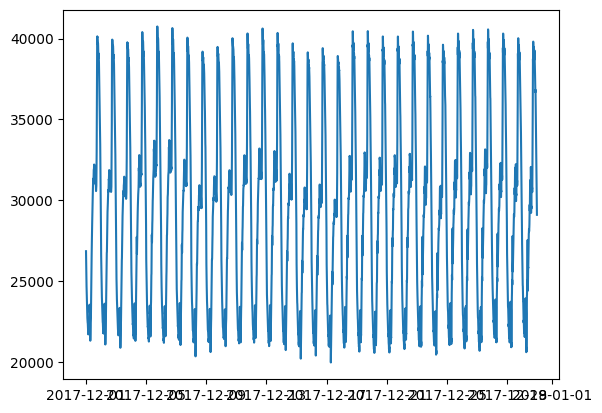

In [750]:
plt.plot(gru_dec)

In [751]:
#gru_dec = pd.DataFrame({"pred":gru_dec})

In [752]:
gru_dec.to_csv("./data/previsioni/LSTM_test_40.csv")

# Validation

In [96]:
arima_val = pd.read_csv("./data/previsioni/arima_validation.csv").set_axis(["Date","y"], axis=1, inplace=False)
ucm_val = pd.read_csv("./data/previsioni/ucm_validation.csv").set_axis(["Date","y"], axis=1, inplace=False)
LSTM_val = pd.read_csv("./data/previsioni/LSTM_validation.csv").set_axis(["Date","y"], axis=1, inplace=False)
arima_val["Date"] = pd.to_datetime(arima_val["Date"])
ucm_val["Date"] = pd.to_datetime(ucm_val["Date"])
LSTM_val["Date"] = pd.to_datetime(LSTM_val["Date"])
arima_val.index = arima_val["Date"]
ucm_val.index = ucm_val["Date"]
LSTM_val.index = LSTM_val["Date"]
arima_val = arima_val.drop("Date",axis=1)
ucm_val = ucm_val.drop("Date",axis=1)
LSTM_val = LSTM_val.drop("Date",axis=1)
validation_prediction = pd.concat([arima_val['y'], ucm_val['y'], LSTM_val['y']], axis=1, keys=['ARIMA', 'UCM', 'ML'])
print(len(arima_val), len(ucm_val), len(LSTM_val)) 

4320 4320 4320


C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\3753577332.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  arima_val = pd.read_csv("./data/previsioni/arima_validation.csv").set_axis(["Date","y"], axis=1, inplace=False)
C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\3753577332.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  ucm_val = pd.read_csv("./data/previsioni/ucm_validation.csv").set_axis(["Date","y"], axis=1, inplace=False)
C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\3753577332.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  LSTM_val = pd.read_csv("./data/previsioni/LSTM_validation.csv").set_axis(["Date","y"], axis=1, inplace

In [97]:
validation_prediction.head()

,ARIMA,UCM,ML
Date,,,
2017-11-01 00:00:00,27607.366020,27974.157112,27523.324800
2017-11-01 00:10:00,27215.217136,27492.589846,27130.078911
2017-11-01 00:20:00,26570.779567,27063.768016,26573.044678
2017-11-01 00:30:00,26215.334078,26683.393090,26214.162336
2017-11-01 00:40:00,25934.911642,26345.489849,25930.717993


In [98]:
df = pd.read_csv("./data/data2022_train.csv")
df = df.set_axis(["Date","y"], axis=1, inplace=False)
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]
df = df.drop("Date",axis=1)

C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\2538017936.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(["Date","y"], axis=1, inplace=False)


In [99]:
df.head()

,y
Date,
2017-01-01 00:00:00,34055.69620
2017-01-01 00:10:00,29814.68354
2017-01-01 00:20:00,29128.10127
2017-01-01 00:30:00,28228.86076
2017-01-01 00:40:00,27335.69620


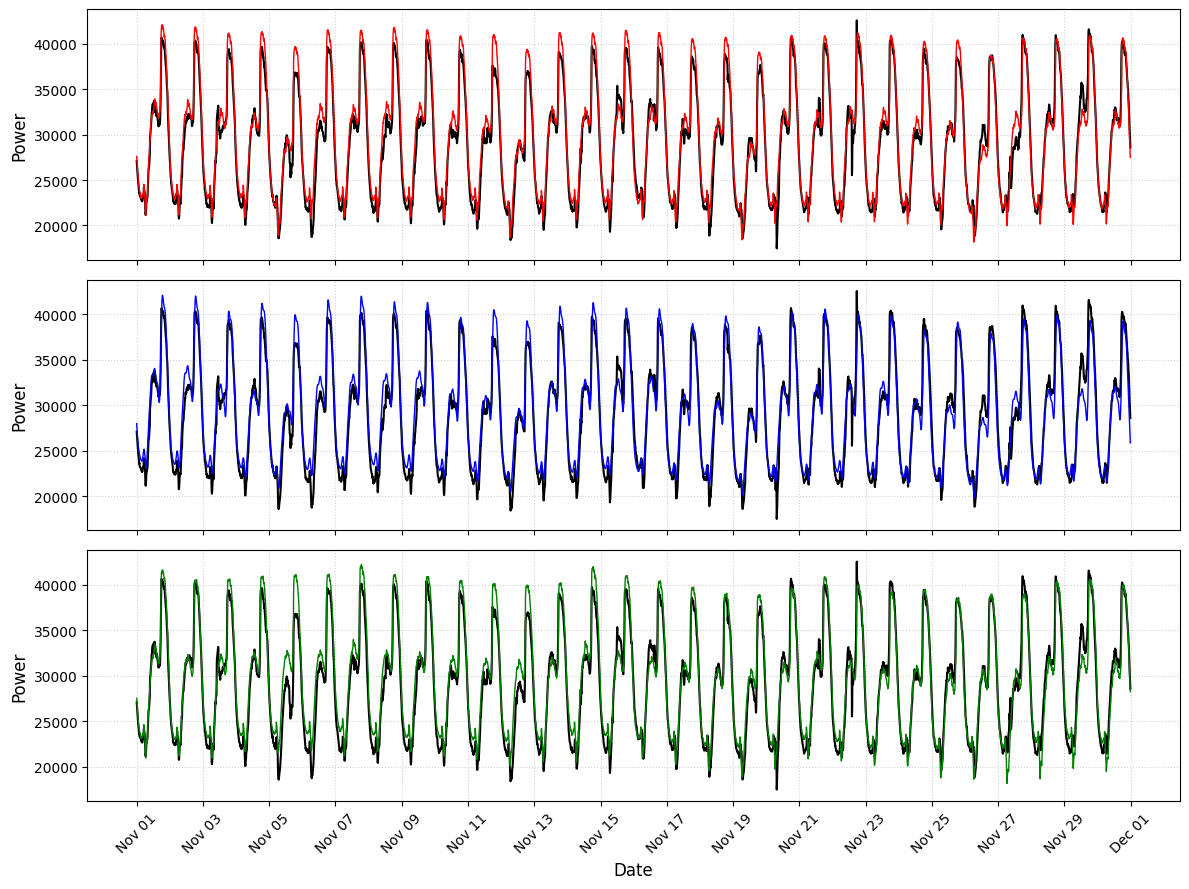

In [104]:
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataset sia chiamato 'dataset' e la colonna 'y' contenga i valori float

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supponiamo che il tuo dataset sia chiamato 'dataset' e la colonna 'y' contenga i valori float

# Seleziona gli ultimi 4320 valori
last_4320_values = df.iloc[-4320:]

# Estrai le date dal tuo indice
dates = pd.to_datetime(last_4320_values.index)

# Crea una figura con tre grafici sovrapposti verticalmente
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Imposta la frequenza di visualizzazione degli tick sull'asse x (circa ogni 3 giorni)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Imposta il formato delle etichette dell'asse x per mostrare solo il mese e il giorno
date_formatter = mdates.DateFormatter('%b %d')
ax3.xaxis.set_major_formatter(date_formatter)

# Seleziona le date desiderate per l'asse x
mask = np.arange(len(dates)) % 3 == 0
x_ticks = dates[mask]

# Grafico 1 - last_4320_values['y']
ax1.plot(dates, last_4320_values['y'], color='black')
ax1.set_ylabel('Power', size = 12)

# Grafico 2 - last_4320_values['y']
ax2.plot(dates, last_4320_values['y'], color='black')
ax2.set_ylabel('Power', size = 12)

# Grafico 3 - last_4320_values['y']
ax3.plot(dates, last_4320_values['y'], color='black')
ax3.set_ylabel('Power', size = 12)
ax3.set_xlabel('Date', size = 12)

# Grafico 1 - validation_prediction['ARIMA']
ax1.plot(dates, validation_prediction['ARIMA'], color='red', lw = 1)


# Grafico 2 - validation_prediction['UCM']
ax2.plot(dates, validation_prediction['UCM'], color='blue', lw = 1)

# Grafico 3 - validation_prediction['ML']
ax3.plot(dates, validation_prediction['ML'], color='green', lw = 1)

# Ruota le etichette dell'asse x di 45 gradi per una migliore leggibilità
plt.xticks(rotation=45)

ax3.annotate('Nov 01', xy=(dates[0], 0), xytext=(10, -20), textcoords='offset')

ax1.grid(color='lightgray', linestyle='dotted')
ax2.grid(color='lightgray', linestyle='dotted')
ax3.grid(color='lightgray', linestyle='dotted')

# Mostra i grafici
plt.tight_layout()
plt.show()


In [102]:
print(mae(last_4320_values, validation_prediction['ARIMA']))
print(mae(last_4320_values, validation_prediction['UCM']))
print(mae(last_4320_values, validation_prediction['ML']))

1010.0747743819651
1183.401568930143
1184.073310313124


# Test set vero

In [78]:
arima_test = pd.read_csv("./data/previsioni/arima_test.csv").set_axis(["Date","y"], axis=1, inplace=False)
ucm_test = pd.read_csv("./data/previsioni/ucm_test_fix.csv").set_axis(["Date","y"], axis=1, inplace=False)
LSTM_test = pd.read_csv("./data/previsioni/LSTM_test_40.csv").set_axis(["Date","y"], axis=1, inplace=False)
arima_test["Date"] = pd.to_datetime(arima_test["Date"])
ucm_test["Date"] = pd.to_datetime(ucm_test["Date"])
LSTM_test["Date"] = pd.to_datetime(LSTM_test["Date"])
arima_test.index = arima_test["Date"]
ucm_test.index = ucm_test["Date"]
LSTM_test.index = LSTM_test["Date"]
arima_test = arima_test.drop("Date",axis=1)
ucm_test = ucm_test.drop("Date",axis=1)
LSTM_test = LSTM_test.drop("Date",axis=1)
test_prediction = pd.concat([arima_test['y'], ucm_test['y'], LSTM_test['y']], axis=1, keys=['ARIMA', 'UCM', 'ML'])
print(len(arima_test), len(ucm_test), len(LSTM_test)) 

4320 4320 4320


C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\2449393599.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  arima_test = pd.read_csv("./data/previsioni/arima_test.csv").set_axis(["Date","y"], axis=1, inplace=False)
C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\2449393599.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  ucm_test = pd.read_csv("./data/previsioni/ucm_test_fix.csv").set_axis(["Date","y"], axis=1, inplace=False)
C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\2449393599.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  LSTM_test = pd.read_csv("./data/previsioni/LSTM_test_40.csv").set_axis(["Date","y"], axis=1, inplace=False)


In [79]:
test_prediction.head()

,ARIMA,UCM,ML
Date,,,
2017-12-01 00:00:00,26601.964752,28040.502828,26854.434500
2017-12-01 00:10:00,26140.710200,27658.283703,26354.082554
2017-12-01 00:20:00,25869.325404,27148.291455,25970.185960
2017-12-01 00:30:00,25333.003062,27047.282447,25480.796275
2017-12-01 00:40:00,24851.288971,26240.557134,25066.357798


In [105]:
test_prediction.to_csv('811974_20230629.csv')

In [80]:
df_real = pd.read_csv(".\data\\real_test.csv")
df_real = df_real.set_axis(["Date","y"], axis=1, inplace=False)
df_real["Date"] = pd.to_datetime(df_real["Date"])
df_real.index = df_real["Date"]
df_real = df_real.drop("Date",axis=1)

C:\Users\giorg\AppData\Local\Temp\ipykernel_22364\1174201844.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_real = df_real.set_axis(["Date","y"], axis=1, inplace=False)


In [81]:
df_real.head()

,y
Date,
2017-12-01 00:00:00,27680.60837
2017-12-01 00:10:00,27011.40684
2017-12-01 00:20:00,26445.62738
2017-12-01 00:30:00,25885.93156
2017-12-01 00:40:00,25277.56654


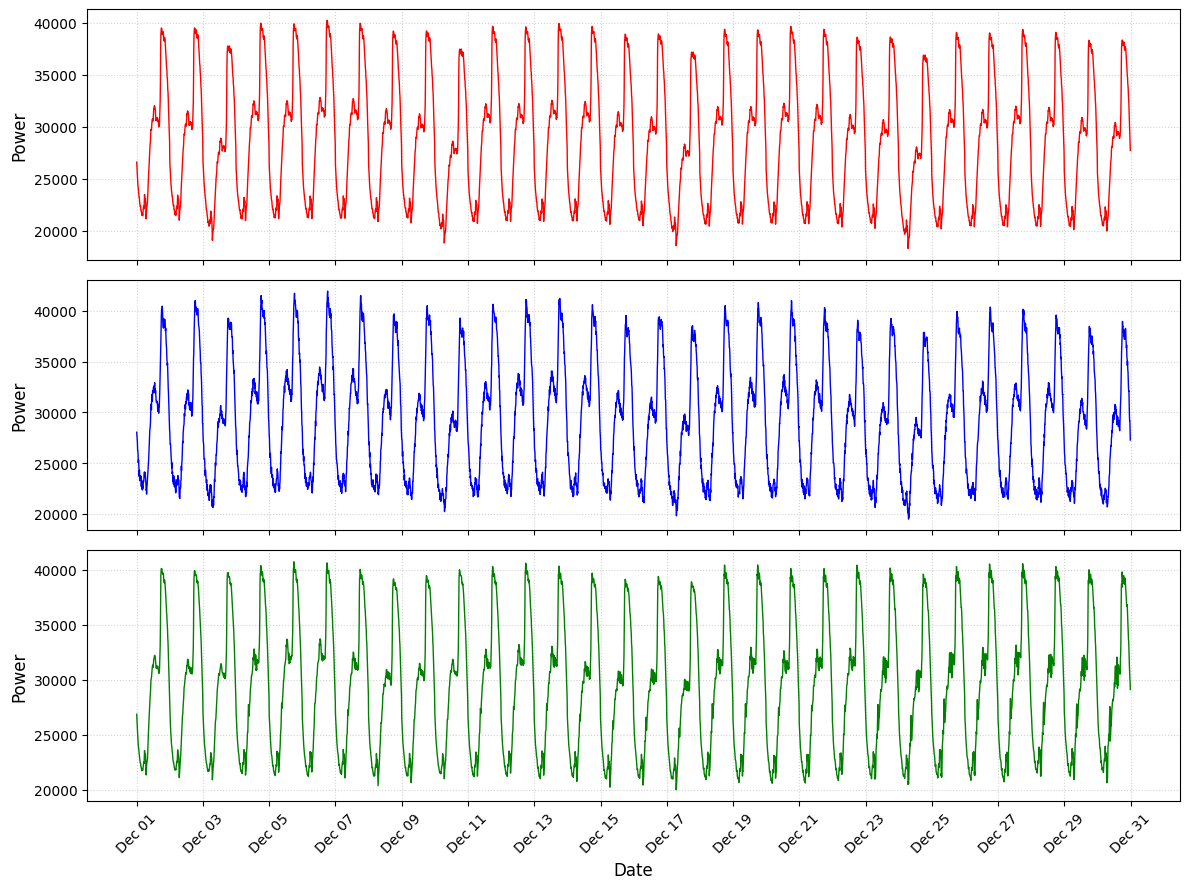

In [103]:
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataset sia chiamato 'dataset' e la colonna 'y' contenga i valori float

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supponiamo che il tuo dataset sia chiamato 'dataset' e la colonna 'y' contenga i valori float

# Seleziona gli ultimi 4320 valori
#last_4320_values = df.iloc[-4320:]

# Estrai le date dal tuo indice
dates = pd.to_datetime(df_real.index)

# Crea una figura con tre grafici sovrapposti verticalmente
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Imposta la frequenza di visualizzazione degli tick sull'asse x (circa ogni 3 giorni)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Imposta il formato delle etichette dell'asse x per mostrare solo il mese e il giorno
date_formatter = mdates.DateFormatter('%b %d')
ax3.xaxis.set_major_formatter(date_formatter)

# Seleziona le date desiderate per l'asse x
mask = np.arange(len(dates)) % 3 == 0
x_ticks = dates[mask]

# Grafico 1 - last_4320_values['y']
ax1.plot(dates, test_prediction['ARIMA'], color='red', lw = 1)
ax1.set_ylabel('Power', size = 12)

# Grafico 2 - last_4320_values['y']
ax2.plot(dates, test_prediction['UCM'], color='blue', lw = 1)
ax2.set_ylabel('Power', size = 12)

# Grafico 3 - last_4320_values['y']
ax3.plot(dates, test_prediction['ML'], color='green', lw = 1)
ax3.set_ylabel('Power', size = 12)
ax3.set_xlabel('Date', size = 12)

# Ruota le etichette dell'asse x di 45 gradi per una migliore leggibilità
plt.xticks(rotation=45)

ax3.annotate('Nov 01', xy=(dates[0], 0), xytext=(10, -20), textcoords='offset')

ax1.grid(color='lightgray', linestyle='dotted')
ax2.grid(color='lightgray', linestyle='dotted')
ax3.grid(color='lightgray', linestyle='dotted')

# Mostra i grafici
plt.tight_layout()
plt.show()


In [83]:
print(mae(df_real, test_prediction['ARIMA']))
print(mae(df_real, test_prediction['UCM']))
print(mae(df_real, test_prediction['ML']))

878.7866808813066
1052.5717687335543
1022.1571229524035


## LSTM

In [10]:
# Importazione del file CSV come DataFrame
real = pd.read_csv(".\data\Tetuan City power consumption.csv")

# Estrazione della colonna "Zone 1 Power Consumption" come serie
zone1_power_consumption = real["Zone 1 Power Consumption"][-4320:].reset_index(drop=True)

In [11]:
type(zone1_power_consumption)

pandas.core.series.Series

In [12]:
zone1_power_consumption

0       27680.60837
1       27011.40684
2       26445.62738
3       25885.93156
4       25277.56654
           ...     
4315    31160.45627
4316    30430.41825
4317    29590.87452
4318    28958.17490
4319    28349.80989
Name: Zone 1 Power Consumption, Length: 4320, dtype: float64

In [18]:
start_date = datetime(2017, 12, 1)
end_date = datetime(2017, 12, 30, 23, 50)
index = pd.date_range(start=start_date, end=end_date, freq="10min")

TypeError: 'module' object is not callable

In [804]:
zone1_power_consumption.shape

(4320,)

In [805]:
zone1_power_consumption.index = index
zone1_power_consumption

2017-12-01 00:00:00    27680.60837
2017-12-01 00:10:00    27011.40684
2017-12-01 00:20:00    26445.62738
2017-12-01 00:30:00    25885.93156
2017-12-01 00:40:00    25277.56654
                          ...     
2017-12-30 23:10:00    31160.45627
2017-12-30 23:20:00    30430.41825
2017-12-30 23:30:00    29590.87452
2017-12-30 23:40:00    28958.17490
2017-12-30 23:50:00    28349.80989
Freq: 10T, Name: Zone 1 Power Consumption, Length: 4320, dtype: float64

In [807]:
zone1_power_consumption.to_csv("./data/real_test.csv")

In [808]:
mae(zone1_power_consumption,gru_dec)

1022.1571229524035

## ARIMA

In [11]:
real = pd.read_csv(".\data\Tetuan City power consumption.csv")
zone1_power_consumption = real["Zone 1 Power Consumption"][-4320:].reset_index(drop=True)

In [12]:
zone1_power_consumption

0       27680.60837
1       27011.40684
2       26445.62738
3       25885.93156
4       25277.56654
           ...     
4315    31160.45627
4316    30430.41825
4317    29590.87452
4318    28958.17490
4319    28349.80989
Name: Zone 1 Power Consumption, Length: 4320, dtype: float64

In [13]:
arima = pd.read_csv("./data/previsioni/arima_test.csv", index_col=0)["y"].reset_index(drop=True)

In [14]:
arima

0       26601.964752
1       26140.710200
2       25869.325404
3       25333.003062
4       24851.288971
            ...     
4315    30461.303225
4316    29731.817959
4317    29029.173225
4318    28394.753631
4319    27733.961550
Name: y, Length: 4320, dtype: float64

In [15]:
mae(zone1_power_consumption,arima)

878.7866808813066